<span style="color:gray">
Copyright &copy; 2020-2021 by Fraunhofer-Gesellschaft. All rights reserved.<br>
Fraunhofer Institute for Integrated Circuits IIS, Division Engineering of Adaptive Systems EAS<br>
Münchner Straße 16, 01187 Dresden, Germany
</span>

---

## ESB - Energy Saving by Blockchain

Eurostars – EXP 00119832 / EUS-2019113348

---

## Prediction of Energy Consumption for Variable Customer Portfolios Including Aleatoric Uncertainty Estimation

*Oliver Mey, André Schneider, Olaf Enge-Rosenblatt, Yesnier Bravo, Pit Stenzel*

The notebook is part of a paper submission contributed to the **10th International Conference on Power Science and Engineering (ICPSE 2021)** held on Oct. 21-23, 2021 in Yildiz Technical University, Istanbul, Turkey.

---

# A2: Data Exploration

This notebook loads and plots the available datasets using a compact DataLoader class implementation.

---

<span style="color:gray">
Version 0.3.9 (October 12, 2021)<br>
Authors: Oliver Mey, André Schneider (Fraunhofer IIS)<br>
</span>    

In [1]:
import warnings, logging, os
warnings.filterwarnings('ignore')
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
import os
import joblib
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays as hd
import seaborn as sns
import tensorflow as tf

%matplotlib inline
sns.set(rc={'figure.figsize':(16, 6)})

### Configuration

In [3]:
path = '..'
timezone = 'Europe/Madrid'
seed = 12345
epsilon = 1e-5
skip = 15

selected_customers =  [1, 3, 5, 6, 13, 16, 22, 38, 297, 406]

In [4]:
properties = {
    'data_path' : path + '/data',
    'models_path' : path + '/models/C1_01',
    'epsilon': epsilon
}

### Function Definitions

In [5]:
def fix_DST(data):
    data = data[~data.index.duplicated(keep='first')]
    data = data.resample('H').ffill()
    return data

def crop(data):
    hour_index = data.index.hour
    t0 = data[hour_index==0].head(1).index
    tn = data[hour_index==23].tail(1).index
    data.drop(data.loc[data.index < t0[0]].index, inplace=True)
    data.drop(data.loc[data.index > tn[0]].index, inplace=True)
    return

### Class Definition for Loading the Data

In [6]:
class DataLoader:
    
    def __init__(self, properties):
        self.data_path = properties.get('data_path', '/tmp')
        self.categories = ['consumption', 'weather', 'profiles']
        self.files = [self.data_path + '/' + '20201015_' + name + '.xlsx' for name in self.categories]
        return
    
    def scale_data(self, data):
        x = data.groupby(data.index.date).mean()
        x.index = pd.to_datetime(x.index)
        x = x.append(pd.DataFrame(x.tail(1), index=x.tail(1).index+pd.Timedelta(days=1)))
        x = x.resample('h').ffill()[:-1]
        x.index = data.index
        y = data / x
        return y
    
    def load_metadata(self):
        customers = pd.read_excel(self.files[self.categories.index('profiles')])
        customers.columns = ['customer', 'profile']
        profiles = pd.DataFrame(customers['profile'].unique(), columns=['profile'])
        holidays = hd.ES(years=list(range(2010, 2021)), prov="MD")
        return customers, profiles, holidays
    
    def load_data(self):
        consumptions = pd.read_excel(self.files[self.categories.index('consumption')], parse_dates=[0], index_col=0)
        consumptions.columns = pd.DataFrame(consumptions.columns, columns=['customer']).index
        consumptions.index.name = 'time'
        consumptions = fix_DST(consumptions)
        crop(consumptions)
        consumptions_scaled = self.scale_data(consumptions)
        weather = pd.read_excel(self.files[self.categories.index('weather')], parse_dates=[0], index_col=0)
        weather.columns = consumptions.columns
        weather.index.name = 'time'
        weather = fix_DST(weather)
        weather_forecast = weather.copy()
        weather_forecast.index = weather.index-pd.Timedelta(days=1)
        crop(weather)
        crop(weather_forecast)
        return consumptions, consumptions_scaled, weather, weather_forecast
    
    def prepare_data(self, consumptions, weather, holidays):
        days = pd.DataFrame(pd.to_datetime(consumptions.index.date), index=consumptions.index, columns=['date'])
        days['day_of_week'] = list(days.index.dayofweek)
        days['day_of_month'] = list(days.index.day)
        days['month'] = list(days.index.month)
        days['day_category'] = days['day_of_week'].replace({0:0,1:1,2:1,3:1,4:2,5:3,6:4})
        days.loc[days['date'].apply(lambda d: d in holidays), 'day_category'] = 4
        days = days.groupby(['date']).first()
        consumptions_daily_mean = pd.DataFrame(consumptions.groupby(consumptions.index.date).mean(), index=days.index)
        weather_daily_mean = pd.DataFrame(weather.groupby(weather.index.date).mean(), index=days.index)
        return consumptions_daily_mean, weather_daily_mean, days

### Loading Data

In [7]:
loader = DataLoader(properties)
consumptions, consumptions_scaled, weather, weather_forecast = loader.load_data()
customers, profiles, holidays = loader.load_metadata()

### Preparing Data

In [8]:
consumptions_daily_mean, weather_daily_mean, days = loader.prepare_data(consumptions, weather, holidays)

### Example Plots for Customer #20

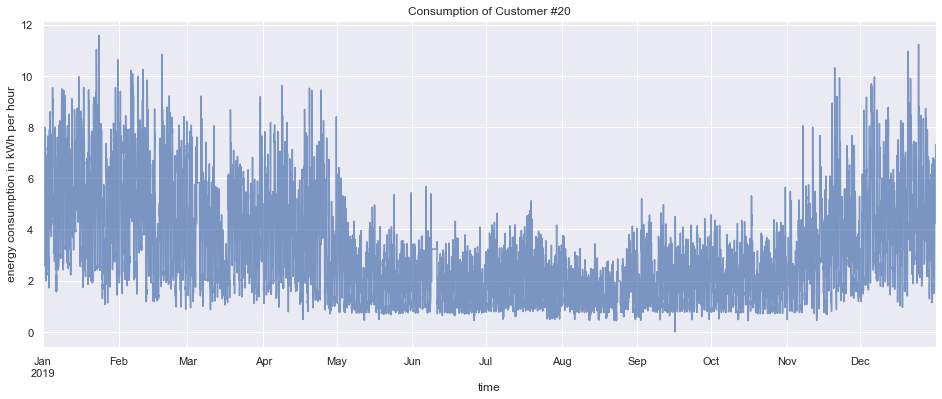

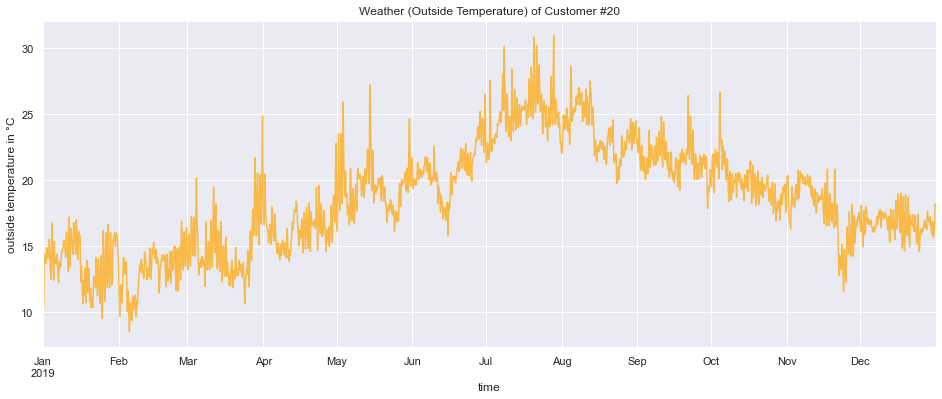

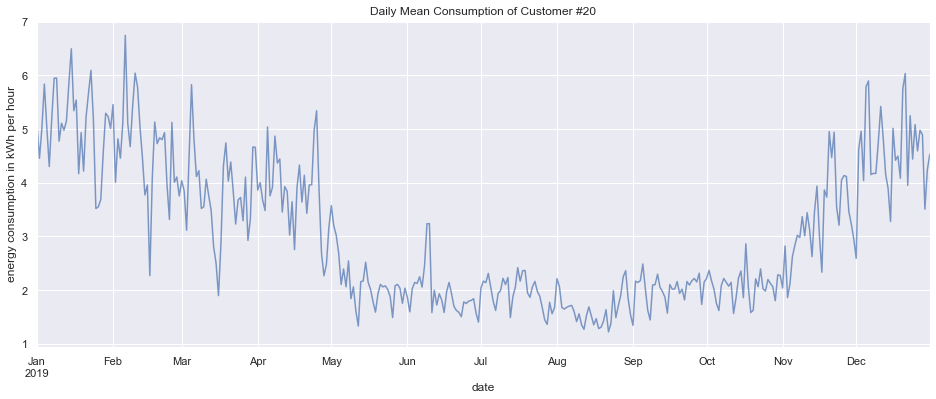

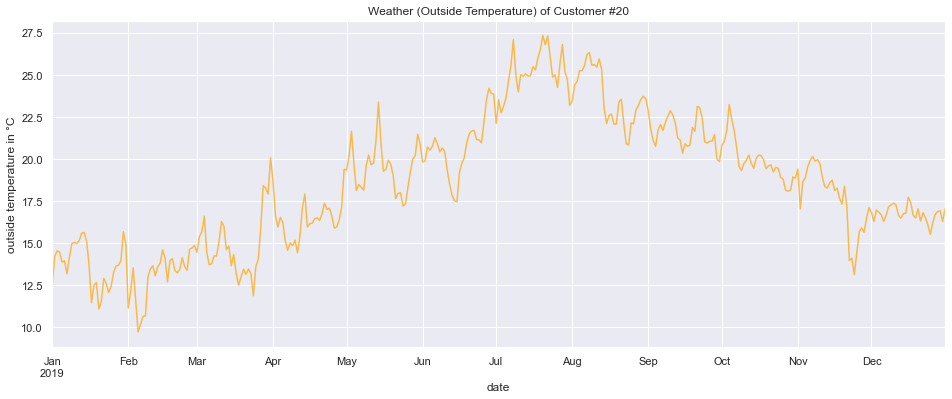

In [9]:
customer = 20

_ = consumptions.loc[:, customer].plot(color='b', alpha=0.7, ylabel='energy consumption in kWh per hour',
                                 title='Consumption of Customer #' + str(customer))
plt.show()

_ = weather.loc[:, customer].plot(color='orange', alpha=0.7, ylabel='outside temperature in °C',
                                 title='Weather (Outside Temperature) of Customer #' + str(customer))
plt.show()

_ = consumptions_daily_mean.loc[:, customer].plot(color='b', alpha=0.7, 
                                                  ylabel='energy consumption in kWh per hour',
                                                  title='Daily Mean Consumption of Customer #' + str(customer))
plt.show()

_ = weather_daily_mean.loc[:, customer].plot(color='orange', alpha=0.7, ylabel='outside temperature in °C',
                                 title='Weather (Outside Temperature) of Customer #' + str(customer))
plt.show()